## Credit Card Kaggle Anamoly Detection

### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

### Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

In [85]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from __future__ import print_function
import time
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [88]:
data = pd.read_csv('creditcard.csv',sep=',')
'''
#data.head()
#just taking 10% of the normal datapoints to reduce the size of dataset (else tsne taking a lot of time)
data_normal=data[data['Class']==0]
data_fraud=data[data['Class']==1]
data_normal=data_normal.sample(frac=0.1,random_state=23)
#data_normal_sample=data_normal.head(28432)     #selecting top 28k rows instead of randomly selecting from entire dataframe
data_sample=pd.concat([data_normal_sample,data_fraud])
data_sample=shuffle(data_sample, random_state=23)  # randomizing the rows (as 'Class'=1 were only at the bottom)
'''

data_sample=data.sample(frac=0.1,random_state=23)   #randomly selecting 10% of data points, irrespective of 'Class'=0 or 1
#Create independent and Dependent Features
columns = data_sample.columns.tolist()
columns = [c for c in columns if c not in ["Class"]]
#target='Class'
X=data_sample[columns]
y=data_sample['Class']
y.head()


# Define a random state, might need this part later 
state = np.random.RandomState(42)
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

In [53]:
#df.sample(frac = 0.5)
y.tail(10)

16497    0
16806    0
28201    0
10519    0
6179     0
9742     0
11238    0
26657    0
9292     0
8817     0
Name: Class, dtype: int64

In [67]:
data_sample.groupby(['Class']).count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,28434,28434,28434,28434,28434,28434,28434,28434,28434,28434,...,28434,28434,28434,28434,28434,28434,28434,28434,28434,28434
1,47,47,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Exploratory Data Analysis

In [73]:
data_sample.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

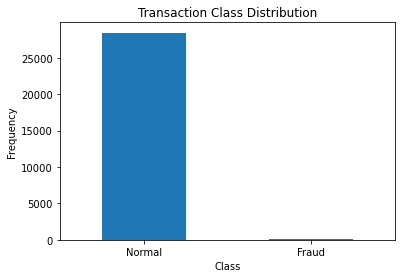

In [68]:
count_classes = pd.value_counts(data_sample['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [76]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data_sample[data_sample['Class']==1]

Valid = data_sample[data_sample['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

print('outlier_fraction: ', outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

outlier_fraction:  0.0016529506928325245
Fraud Cases : 47
Valid Cases : 28434


2D tsne diagram to see the distribution of datapoints

In [69]:
#2D tsne
time_start = time.time()
tsne = TSNE(n_components=2, verbose=10, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 28481 samples in 0.001s...
[t-SNE] Computed neighbors for 28481 samples in 15.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28481
[t-SNE] Computed conditional probabilities for sample 2000 / 28481
[t-SNE] Computed conditional probabilities for sample 3000 / 28481
[t-SNE] Computed conditional probabilities for sample 4000 / 28481
[t-SNE] Computed conditional probabilities for sample 5000 / 28481
[t-SNE] Computed conditional probabilities for sample 6000 / 28481
[t-SNE] Computed conditional probabilities for sample 7000 / 28481
[t-SNE] Computed conditional probabilities for sample 8000 / 28481
[t-SNE] Computed conditional probabilities for sample 9000 / 28481
[t-SNE] Computed conditional probabilities for sample 10000 / 28481
[t-SNE] Computed conditional probabilities for sample 11000 / 28481
[t-SNE] Computed conditional probabilities for sample 12000 / 28481
[t-SNE] Computed conditional probabilities for s

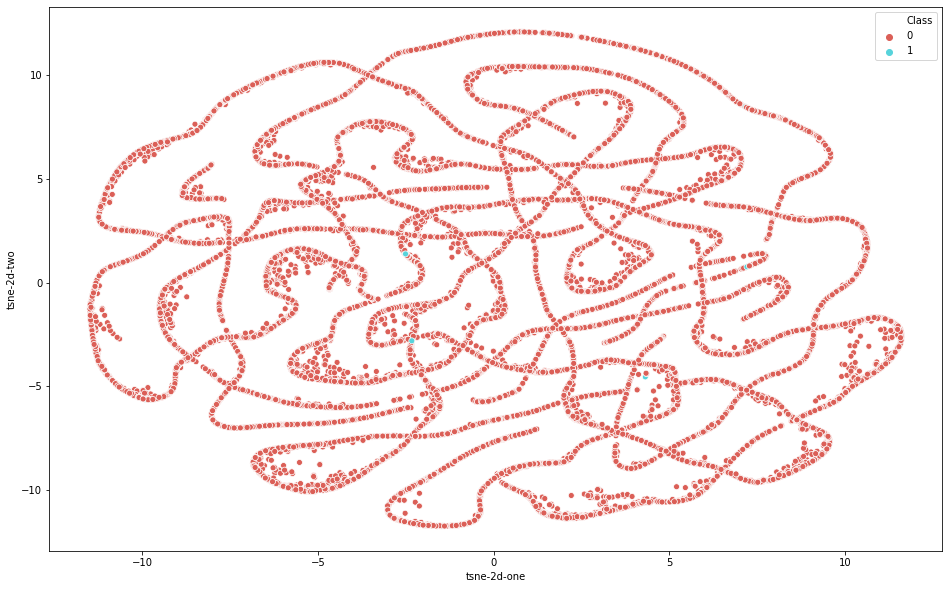

In [70]:
#2D tsne plot 
data_sample['tsne-2d-one'] = tsne_results[:,0]
data_sample['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='Class',
    palette=sns.color_palette("hls", 2),
    data=data_sample,
    #data=df_sub,
    legend="full",
    alpha=1
)  # the blue points correspons to fraud, red ones corresponds to normal 

In [89]:
## Get the Fraud and the normal dataset 

fraud = data_sample[data_sample['Class']==1]

normal = data_sample[data_sample['Class']==0]

In [90]:
print(fraud.shape,normal.shape)

(47, 31) (28434, 31)


In [91]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.Amount.describe()

count      47.000000
mean      152.314043
std       335.773320
min         0.000000
25%         1.000000
50%         9.820000
75%        99.990000
max      1402.160000
Name: Amount, dtype: float64

In [92]:
normal.Amount.describe()

count    28434.000000
mean        87.568431
std        243.144701
min          0.000000
25%          5.490000
50%         21.895000
75%         76.495000
max      11789.840000
Name: Amount, dtype: float64

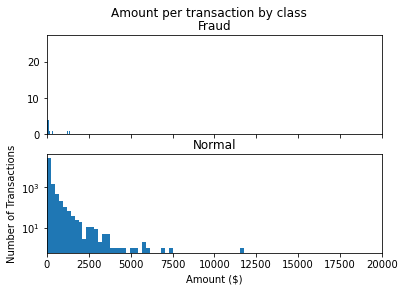

In [93]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

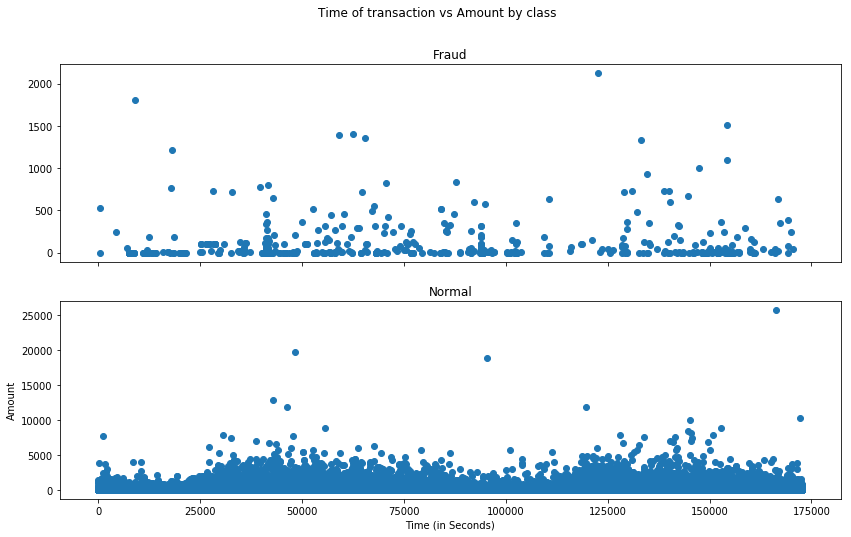

In [16]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(Fraud.Time, Fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(Normal.Time, Normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

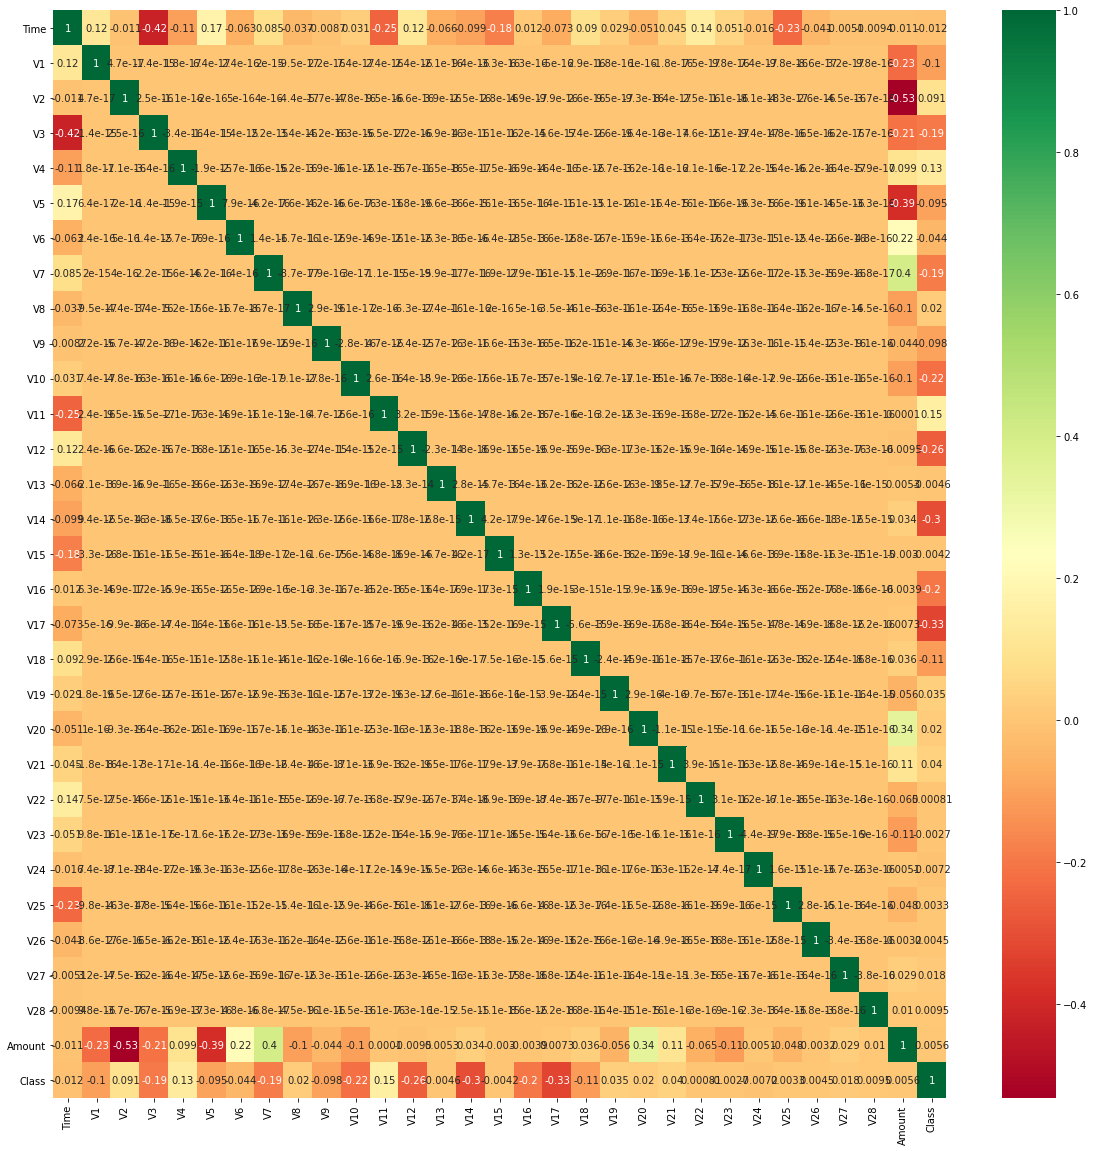

In [94]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = data_sample.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Model Prediction





Now it is time to start building the model .The types of algorithms we are going to use to try to do anomaly detection on this dataset are as follows

### Isolation Forest Algorithm :
One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work
The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.


### Local Outlier Factor(LOF) Algorithm
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [95]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction)
    #"Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         #max_iter=-1)
   
}

In [78]:
state

RandomState(MT19937) at 0x2080040FC40

In [80]:
type(classifiers)

dict

In [96]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    #elif clf_name == "Support Vector Machine":
        #clf.fit(X)
        #y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y,y_pred))
    print("Classification Report :")
    print(classification_report(y,y_pred))
    print('confusion matrix: ')
    print(confusion_matrix(y, y_pred))

Isolation Forest: 59
Accuracy Score :
0.9979284435237527
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28434
           1       0.38      0.38      0.38        47

    accuracy                           1.00     28481
   macro avg       0.69      0.69      0.69     28481
weighted avg       1.00      1.00      1.00     28481

confusion matrix: 
[[28404    30]
 [   29    18]]
Local Outlier Factor: 95
Accuracy Score :
0.9966644429619747
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28434
           1       0.00      0.00      0.00        47

    accuracy                           1.00     28481
   macro avg       0.50      0.50      0.50     28481
weighted avg       1.00      1.00      1.00     28481

confusion matrix: 
[[28386    48]
 [   47     0]]


#### Observations :
- Isolation Forest detected 73 errors versus Local Outlier Factor detecting 97 errors vs. SVM detecting 8516 errors
- Isolation Forest has a 99.74% more accurate than LOF of 99.65% and SVM of 70.09
- When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0%.
- So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.
- We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases